<div>
<img img class="logo" src="https://medialib.cmcdn.dk/medialibrary/51432DDB-BBE3-4327-85F4-BE3493077470/1D874B35-F493-EC11-84B2-00155D0B0901.png" style="width: 100px;" align="right">
</div>

# <center> Assignment 2 - BuyWise Analytics

### <center> KAN-CDSCV1008U  Applied Machine Learning and Data Engineering in Business Context

## Data Preprocessing

In [188]:
# Importing modules 
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os

from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, accuracy_score

In [189]:
# Importing datasets 
path_frederik = "C:/Users/fredr/OneDrive/Documents/Master/Semester_3/Applied ML/AppliedML_Assign.01/Assignment2/Data/Features data set.csv"
path_mathijs = "C:/Users/blk/OneDrive/Documenten/GitHub/ML-Final/AppliedML_Assign.01/Assignment2/Data"

os.chdir(path_mathijs)
print(os.getcwd())

features = pd.read_csv("Features data set.csv")
sales = pd.read_csv("sales data-set.csv")
stores = pd.read_csv("stores data-set.csv")

C:\Users\blk\OneDrive\Documenten\GitHub\ML-Final\AppliedML_Assign.01\Assignment2\Data


In [190]:
print(
    features.columns, '\n',
    sales.columns,'\n',
    stores.columns
)

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object') 
 Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object') 
 Index(['Store', 'Type', 'Size'], dtype='object')


In [191]:
# Convert the date column to datetime format 
features["Date"] = pd.to_datetime(features["Date"], format="%d/%m/%Y")
sales["Date"] = pd.to_datetime(sales["Date"], format="%d/%m/%Y")

`Data Prep`

In [192]:
def create_dummies_and_drop(data, columns):
    for col in columns:
        one_hot = pd.get_dummies(data[col],prefix=col).astype(int)
        data = data.join(one_hot)
        data.drop(col,axis = 1,inplace=True)
    
    return data

1. Group sales by date and store
2. merge features and sales by date and store on date and store
3. merge stores with the above.

In [193]:
sales_date_store = sales.groupby(["Date","Store"]).agg({"Weekly_Sales":"sum"})
sales_date_store.sort_index(inplace=True)
df = pd.merge(features,sales_date_store ,  how='left', on=["Date","Store"])
df = pd.merge(df, stores[["Store", "Type"]],  how='left', on=["Store"])

In [194]:
df.columns
df.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
Weekly_Sales    1755
Type               0
dtype: int64

In [195]:
# Forwoard fill impution for 'CPI' and 'Unemployment'
df['CPI'].fillna(method='ffill', inplace=True)
df['Unemployment'].fillna(method='ffill', inplace=True)

In [196]:
# Create time columns
df['year'] = df.Date.dt.year
df['quarter'] = df.Date.dt.quarter
df['month'] = df.Date.dt.month
df['week'] = df.Date.dt.isocalendar().week

In [197]:
# Imputing Markdown columns
# Impute NaN values based on weekly average
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_columns:
    weekly_avg = df.groupby('week')[col].transform('mean')
    df[col].fillna(weekly_avg, inplace=True)

# can't impute all values for MarkDown2 , dropping Markdown2.

df.drop('MarkDown2', axis = 1, inplace=True)
print(df.head())
df.shape

   Store       Date  Temperature  Fuel_Price     MarkDown1   MarkDown3   
0      1 2010-02-05        42.31       2.572  24089.612333  198.031818  \
1      1 2010-02-12        38.51       2.548  29880.900556  197.092500   
2      1 2010-02-19        39.93       2.514  12536.748111   59.385610   
3      1 2010-02-26        46.63       2.561   8504.312444   25.995714   
4      1 2010-03-05        46.50       2.625  11293.039000   22.353662   

      MarkDown4    MarkDown5         CPI  Unemployment  IsHoliday   
0  24865.942619  4185.380333  211.096358         8.106      False  \
1  20305.431829  5089.147556  211.242170         8.106       True   
2   7038.310625  5646.276000  211.289143         8.106      False   
3   2879.735679  4458.685000  211.319643         8.106      False   
4   6312.144304  2911.005778  211.350143         8.106      False   

   Weekly_Sales Type  year  quarter  month  week  
0    1643690.90    A  2010        1      2     5  
1    1641957.44    A  2010        1   

(8190, 17)

In [198]:
#create dummies out of categorical column
df = create_dummies_and_drop(df,["Store","Type","month","year","week"])

In [199]:
df.shape

(8190, 128)

#### Model prep

In [200]:
for col in df.columns:
    num_nan = df[col].isna().sum()  # count the NaN values in the column
    if num_nan > 0:
        print(f"Column {col} has {num_nan} NaN values.")


Column Weekly_Sales has 1755 NaN values.


In [201]:
df.set_index("Date", inplace=True)
df.head()

,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,42.31,2.572,24089.612333,198.031818,24865.942619,4185.380333,211.096358,8.106,False,1643690.90,...,0,0,0,0,0,0,0,0,0,0
2010-02-12,38.51,2.548,29880.900556,197.092500,20305.431829,5089.147556,211.242170,8.106,True,1641957.44,...,0,0,0,0,0,0,0,0,0,0
2010-02-19,39.93,2.514,12536.748111,59.385610,7038.310625,5646.276000,211.289143,8.106,False,1611968.17,...,0,0,0,0,0,0,0,0,0,0
2010-02-26,46.63,2.561,8504.312444,25.995714,2879.735679,4458.685000,211.319643,8.106,False,1409727.59,...,0,0,0,0,0,0,0,0,0,0
2010-03-05,46.50,2.625,11293.039000,22.353662,6312.144304,2911.005778,211.350143,8.106,False,1554806.68,...,0,0,0,0,0,0,0,0,0,0


In [202]:
data_train = df[df.Weekly_Sales.notnull()]
data_test = df[df.Weekly_Sales.isnull()]
X = data_train.drop('Weekly_Sales', axis=1)
y = data_train['Weekly_Sales']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [203]:
# # Splitting the data to not include Weekly Sales NaN values
# data_train = df[df.Weekly_Sales.notnull()]
# data_test = df[df.Weekly_Sales.isnull()]

# # Splitting the data into train- and test set by index
# data_train.reset_index(inplace=True)
# split_indx = int(0.8*len(data_train))
# train = data_train[:split_indx].set_index('Date')
# test = data_train[split_indx:].set_index('Date')

# # filtering out the target variable
# X_train = train.drop('Weekly_Sales', axis=1)
# X_test = test.drop('Weekly_Sales', axis=1)
# y_train = train['Weekly_Sales']
# y_test = test['Weekly_Sales']

In [204]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [205]:
# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [206]:
# Initialize Linear Regression 
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [207]:
print('Mean Absolute Error:', mean_absolute_error(y_test, lr_pred))
print('Mean Squared Error:', mean_squared_error(y_test, lr_pred))
print('R-squared:', r2_score(y_test, lr_pred))

Mean Absolute Error: 67965.1914103892
Mean Squared Error: 11537738159.635757
R-squared: 0.9651569972766826


In [ ]:
# Plotting the visualizations 

# Getting the predicted values from the regressor 
test['OSL_Predictions'] = lr_pred

# Grouping the testset to prepare for visualizations
test.reset_index(inplace=True)
test_date = test.groupby('Date').agg({'Weekly_Sales': 'mean',
                                        'OSL_Predictions': 'mean'}).reset_index()

# Plotting both 'Weekly_Sales' and 'Predictions'
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(test_date['Date'], test_date['Weekly_Sales'], label='Weekly Sales')
ax.plot(test_date['Date'], test_date['OSL_Predictions'], label='OSL_Predictions')

# Adding labels and title
ax.set_ylabel("Weekly Sales (Mean)")
ax.set_title('Predicted Weekly Sales')
ax.legend()

# Displaying the plot
plt.show()

In [209]:
# Initialize XGBoost Regressor
xgb = XGBRegressor(n_estimators=1000)
xgb.fit(X_train,y_train, verbose=False)
xgb_pred = xgb.predict(X_test)

In [210]:
print('Mean Absolute Error:', mean_absolute_error(y_test, xgb_pred))
print('Mean Squared Error:', mean_squared_error(y_test, xgb_pred))
print('R-squared:', r2_score(y_test, xgb_pred))

Mean Absolute Error: 44665.157629662
Mean Squared Error: 5307718348.225347
R-squared: 0.9839711352170557


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

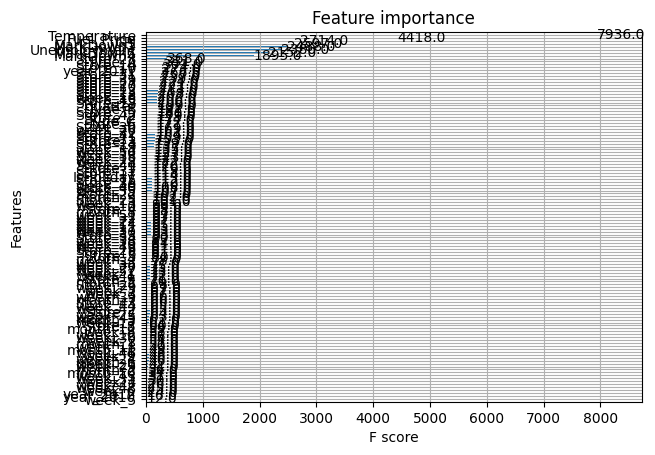

In [211]:
from xgboost import plot_importance
plot_importance(xgb)

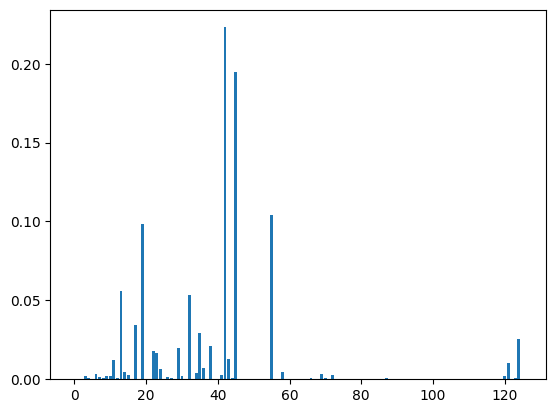

In [101]:
# plot
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

In [212]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [213]:
print('Mean Absolute Error:', mean_absolute_error(y_test, rf_pred))
print('Mean Squared Error:', mean_squared_error(y_test, rf_pred))
print('R-squared:', r2_score(y_test, rf_pred))

Mean Absolute Error: 54769.85773209013
Mean Squared Error: 10630102422.080296
R-squared: 0.967897981171261


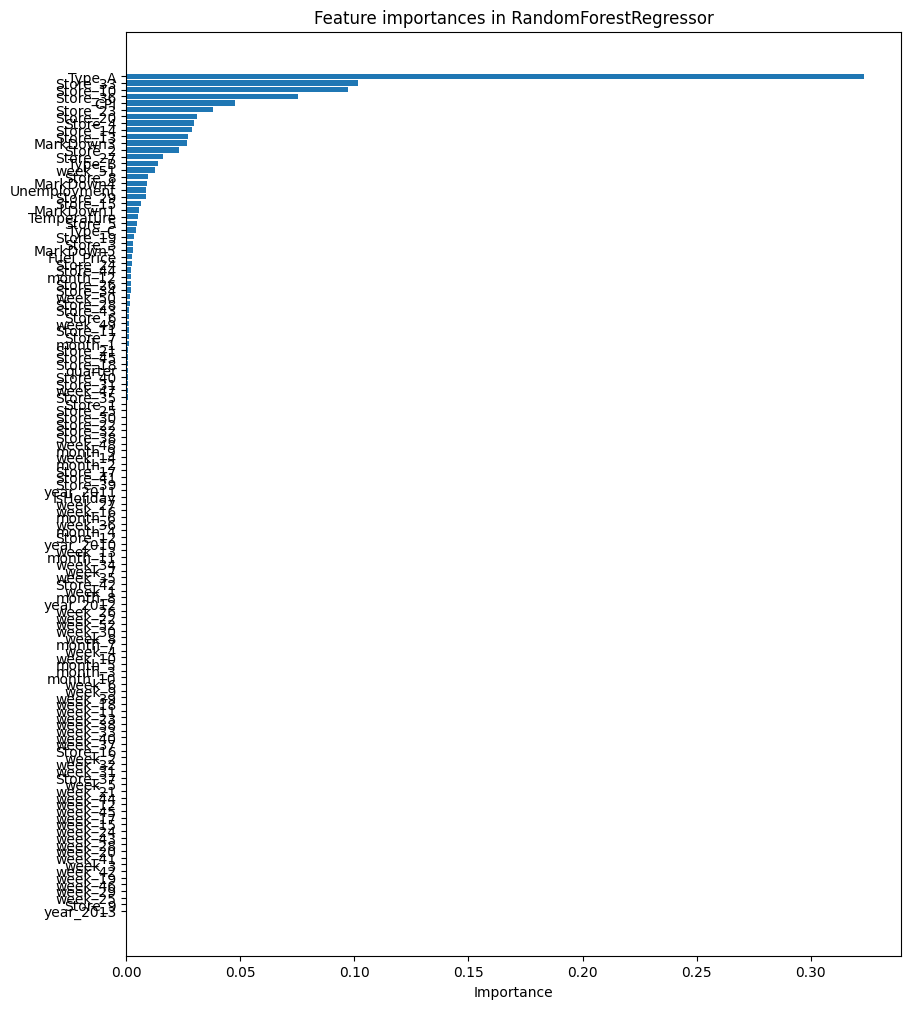

In [214]:
feature_importance = rf.feature_importances_
sorted_idx = feature_importance.argsort()
8
plt.figure(figsize=(10, 12))
plt.barh(range(X_train.shape[1]), feature_importance[sorted_idx])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances in RandomForestRegressor')
plt.show()

In [252]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_



KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_rf.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))    
print('R-squared:', r2_score(y_test, y_pred))

Mean Absolute Error: 611.715203641342
Mean Squared Error: 588614.6902963762
R-squared: -0.7152370899178142


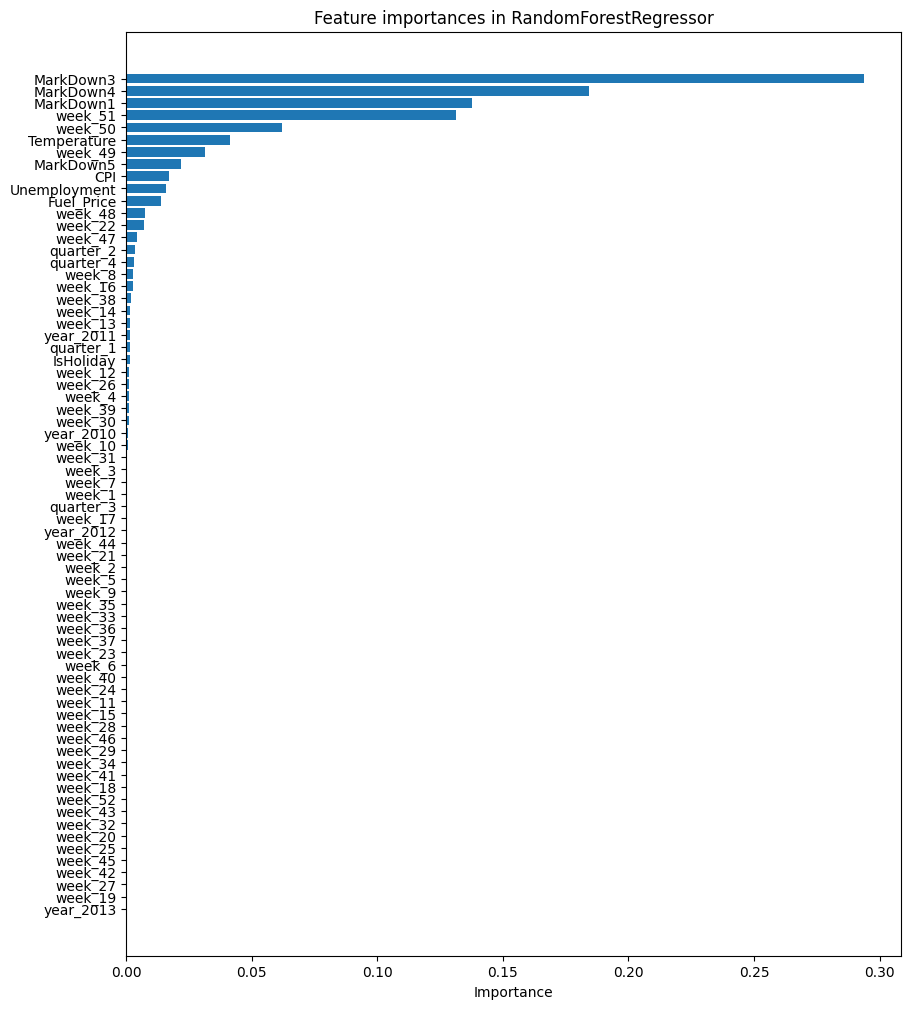

In [ ]:
feature_importance = best_rf.feature_importances_
sorted_idx = feature_importance.argsort()

plt.figure(figsize=(10, 12))
plt.barh(range(X_train.shape[1]), feature_importance[sorted_idx])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances in RandomForestRegressor')
plt.show()